In [1]:
%load_ext autoreload
%matplotlib inline

%autoreload 2

# %load_ext watermark
# %watermark -v -n -m -p numpy,scipy,sklearn,pandas,tensorflow,keras



In [2]:
from data.preprocess import PreProcessor

# data = PreProcessor(config=PreProcessor.DEFAULT_CONFIG,
#                     data_dir='data/raw/r252-corpus-features/org/elasticsearch/action/admin/')
data = PreProcessor(config=PreProcessor.DEFAULT_CONFIG,
                    data_dir='data/raw/r252-corpus-features/org/elasticsearch/')

vocab = data.metadata['token_vocab']
processed = data.get_tensorise_data()


Failed to load data from path: data/raw/r252-corpus-features/org/elasticsearch/indices/recovery/RecoveryTargetHandler.java.proto. Exception: Failed to separate the method name and body from the token. Method tokens: [['void'], ['receive', 'file', 'info'], ['lparen'], ['list'], ['lt'], ['string'], ['gt'], ['phase', 'file', 'names'], ['comma'], ['list'], ['lt'], ['long'], ['gt'], ['phase', 'file', 'sizes'], ['comma'], ['list'], ['lt'], ['string'], ['gt'], ['phase', 'existing', 'file', 'names'], ['comma'], ['list'], ['lt'], ['long'], ['gt'], ['phase', 'existing', 'file', 'sizes'], ['comma'], ['int'], ['total', 'translog', 'ops'], ['rparen'], ['semi']]


Failed to load data from path: data/raw/r252-corpus-features/org/elasticsearch/index/mapper/ScaledFloatFieldMapper.java.proto. Exception: Failed to separate the method name and body from the token. Method tokens: [['public'], ['builder'], ['scaling', 'factor'], ['lparen'], ['double'], ['scaling', 'factor'], ['rparen'], ['lbrace'], ['lparen'], ['lparen'], ['scaled', 'float', 'field', 'type'], ['rparen'], ['field', 'type'], ['rparen'], ['dot'], ['set', 'scaling', 'factor'], ['lparen'], ['scaling', 'factor'], ['rparen'], ['semi'], ['scaling', 'factor', 'set'], ['eq'], ['true'], ['semi'], ['return'], ['this'], ['semi'], ['rbrace']]


Failed to load data from path: data/raw/r252-corpus-features/org/elasticsearch/indices/cluster/IndicesClusterStateService.java.proto. Exception: Failed to separate the method name and body from the token. Method tokens: [['void'], ['update', 'shard', 'state'], ['lparen'], ['shard', 'routing'], ['shard', 'routing'], ['comma'], ['long'], ['primary', 'term'], ['comma'], ['bi', 'consumer'], ['lt'], ['index', 'shard'], ['comma'], ['action', 'listener'], ['lt'], ['resync', 'task'], ['gtgt'], ['primary', 'replica', 'syncer'], ['comma'], ['long'], ['applying', 'cluster', 'state', 'version'], ['comma'], ['set'], ['lt'], ['string'], ['gt'], ['in', 'sync', 'allocation', 'ids'], ['comma'], ['index', 'shard', 'routing', 'table'], ['routing', 'table'], ['comma'], ['set'], ['lt'], ['string'], ['gt'], ['pre', 'allocation', 'ids'], ['rparen'], ['throws'], ['ioe', 'xception'], ['semi']]


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import layers

from models.cnn_attention import ConvAttention
from utils.activations import masked_sparse_cross_entropy_loss

embedding_dim = 128
vocabulary_size = len(vocab) + 2
max_chunk_length = data.config['max_chunk_length']
code_snippet = processed['body_tokens']
# code_snippet = np.expand_dims(processed['body_tokens'], 0)
# label_name = np.expand_dims(processed['name_tokens'], -1)
label_name = processed['name_tokens']
# label_name = keras.utils.to_categorical(processed['name_tokens'], num_classes=vocabulary_size)
print("Vocab Size: {} Code snippet len: {} label_name len: {}".format(vocabulary_size, len(code_snippet),
                                                                      len(label_name)))

# TODO make the input a json file and parse it
batch_size = 1
k1 = 8
k2 = 8
w1 = 24
w2 = 29
w3 = 10
dropout_rate = 0.5

# Optimised hyperparameter are reported in page 5 of the paper

# define layers
main_input = layers.Input(shape=(max_chunk_length,),
                          batch_size=batch_size,
                          dtype=tf.int32, name='main_input')

cnn_layer = ConvAttention(vocabulary_size=vocabulary_size,
                          embedding_dim=embedding_dim,
                          max_chunk_length=max_chunk_length,
                          k1=k1,
                          k2=k2,
                          w1=w1,
                          w2=w2,
                          w3=w3,
                          dropout_rate=dropout_rate)

optimizer = keras.optimizers.Nadam()  # RMSprop with Nesterov momentum
loss_func = masked_sparse_cross_entropy_loss
#loss_func =  keras.losses.sparse_categorical_crossentropy

# define execution
cnn_output = cnn_layer(main_input)
model = keras.Model(inputs=[main_input], outputs=cnn_output)
model.compile(optimizer=optimizer,
              loss=loss_func,
              # metrics=['sparse_categorical_accuracy'],
              )
# fit the model
# tbCallBack = 
# keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
history = model.fit(code_snippet,
                    label_name,
                    epochs=50,
                    verbose=2,
                    batch_size=batch_size,
                    # callbacks=[tbCallBack],
                    validation_split=0.2)


Vocab Size: 5002 Code snippet len: 17893 label_name len: 17893
Instructions for updating:
Colocations handled automatically by placer.


ConvAttention: Tokens shape = (1, 100, 128), h_t shape = (1, 8)
AttentionFeatures: C shape = (1, 100, 128), h_t shape = (1, 8)
AttentionFeatures: L_1 shape = (1, 100, 8)
AttentionFeatures: L_2 shape = (1, 100, 8)
AttentionFeatures: L_2 shape  after multiply = (1, 100, 8)
AttentionFeatures: L_feat shape = (1, 100, 8)
ConvAttention: L_feat shape = (1, 100, 8)
AttentionWeights: l_feat shape = (1, 100, 8)
AttentionWeights: attention_weight shape = (1, 100, 1)
ConvAttention: alpha shape = (1, 100)
ConvAttention: n_hat shape = (1, 100)
ConvAttention: n shape = (1, 100, 5002)
yPred: Tensor("loss/conv_attention_loss/mul_1:0", shape=(1, 100, 5002), dtype=float32) 
yTrue: Tensor("loss/conv_attention_loss/mul:0", shape=(?, ?, ?), dtype=float32)
Train on 14314 samples, validate on 3579 samples


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Epoch 1/50


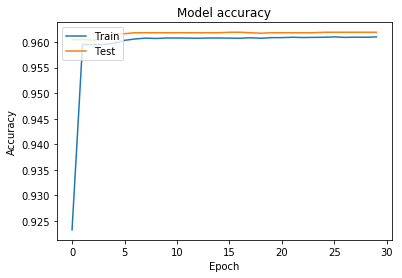

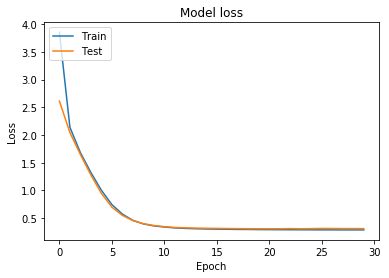

In [29]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [6]:
# # overfit and evaluate the model 
loss, accuracy = model.evaluate(code_snippet, label_name, batch_size=1, verbose=0)
print('Accuracy: {}'.format(accuracy * 100))


Accuracy: 166.93180203437805


In [43]:
# translate prediction

from data.utils import translate_tokenized_array_to_list_words


# model.reset_states()
prediction = model.predict(code_snippet[21].reshape(1, -1)[0][:].reshape(1, -1), steps=100)
# translate_tokenized_array_to_list_words(vocab, label_name[7][0])
translate_tokenized_array_to_list_words(vocab, prediction.argmax(2)[0])
# print(prediction.argmax(2))


['relocating',
 'resolve',
 'get',
 'resolve',
 'current',
 'get',
 'get',
 'get',
 'get',
 'get',
 'get',
 'version',
 'resolve',
 'resolve',
 'get',
 'get',
 'get',
 'get',
 'get',
 'get',
 'get',
 'get',
 'get',
 'get',
 'current',
 'get',
 'not',
 'version',
 'resolve',
 'resolve',
 'get',
 'resolve',
 'current',
 'get',
 'get',
 'get',
 'get',
 'get',
 'version',
 'version',
 'get',
 'version',
 'get',
 'get',
 'get',
 'get',
 'resolve',
 'get',
 'version',
 'get',
 'current',
 'get',
 'get',
 'get',
 'get',
 'get',
 'get',
 'get',
 'get',
 'current',
 'get',
 'get',
 'get',
 'current',
 'settings',
 'get',
 'resolve',
 'get',
 'current',
 'get',
 'get',
 'get',
 'get',
 'get',
 'get',
 'get',
 'version',
 'get',
 'get',
 'version',
 'get',
 'resolve',
 'get',
 'get',
 'resolve',
 'get',
 'resolve',
 'get',
 'get',
 'version',
 'get',
 'current',
 'get',
 'get',
 'get',
 'get',
 'get',
 'get',
 'get',
 'get']

In [85]:
model.predict(code_snippet[0].reshape(1, -1)).argmax(2).shape

(1, 100)

In [80]:
prediction.sum()

100.00005

In [128]:
np.expand_dims(processed['name_tokens'], 1).shape

(518, 1, 100)

In [34]:
# Run model.reset_states() while generating predictions
code_snippet[21].reshape(1, -1)[0][0:].reshape(1, -1)

array([[ 20,   8,   4,  17,   9,   2,   3,   5,  14,  19,   2, 184,   6,
          8,   4,  18,  22,   2,   3,   3,   5,  14,  19,   2,   9,   4,
         48,  98,   6,   8,   4,  17,   9,   2,   3,   3,   5,  74, 149,
         56,  12,  79,   5,   1,  80,  60,  49,  12, 185,  11,  53,   4,
         95,   2,   3,   5,  87,   2,  80,  66,  12,  45,   5,  66,  86,
         60,  49,   5,  66, 128,   3,  15,  34,  11,  22,  12,  75,  11,
         10, 148,   2,   8,   3,   5,  13,  10,  13,  10,  12, 185,  11,
         53,   4,  23,   2,  11,  22,   3,   5,  14]])

In [42]:
prediction[0].argmin(1)

array([ 99, 171,  23, 171,  18,  23,  23,  23,  23,  23,  23,  82, 171,
       171,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  18,  23,
        55,  82, 171, 171,  23, 171,  18,  23,  23,  23,  23,  23,  82,
        82,  23,  82,  23,  23,  23,  23, 171,  23,  82,  23,  18,  23,
        23,  23,  23,  23,  23,  23,  23,  18,  23,  23,  23,  18, 112,
        23, 171,  23,  18,  23,  23,  23,  23,  23,  23,  23,  82,  23,
        23,  82,  23, 171,  23,  23, 171,  23, 171,  23,  23,  82,  23,
        18,  23,  23,  23,  23,  23,  23,  23,  23])

In [21]:
code_snippet = processed['body_tokens']
label_name = processed['name_tokens']
dataset = tf.data.Dataset.from_tensor_slices((code_snippet, label_name))
dataset = dataset.shuffle(1000).batch(32)

for code_block, labels in dataset.take(1):
    print(labels.shape)
    print(code_block.shape)
    print("Logits: ", model(code_block[0:1]).numpy())


(26, 100)
(26, 100)
ConvAttention: Tokens shape = (1, 100, 128), h_t shape = (1, 8)
AttentionFeatures: C shape = (1, 100, 128), h_t shape = (1, 8)
AttentionFeatures: L_1 shape = (1, 100, 8)
AttentionFeatures: L_2 shape = (1, 100, 8)
AttentionFeatures: L_2 shape  after multiply = (1, 100, 8)
AttentionFeatures: L_feat shape = (1, 100, 8)
ConvAttention: L_feat shape = (1, 100, 8)
AttentionWeights: l_feat shape = (1, 100, 8)
AttentionWeights: attention_weight shape = (1, 100, 1)
ConvAttention: alpha shape = (1, 100)
ConvAttention: n_hat shape = (1, 100)
ConvAttention: n shape = (1, 100, 191)
Logits:  [[[5.9777009e-01 5.8181704e-05 2.9912908e-06 ... 2.4725914e-06
   3.3647548e-06 3.8998460e-06]
  [3.9564195e-01 7.0791319e-03 2.4199549e-03 ... 2.2008424e-03
   2.3571230e-03 2.5163309e-03]
  [1.9246221e-02 6.2858281e-03 5.0085140e-03 ... 4.9344958e-03
   4.9549858e-03 5.0268038e-03]
  ...
  [9.5200855e-03 5.3483970e-03 5.1476466e-03 ... 5.1597916e-03
   5.1457300e-03 5.1357392e-03]
  [9.52008

In [20]:
dataset

<DatasetV1Adapter shapes: ((?, 100, 1), (?, 100)), types: (tf.float32, tf.int64)>